# Fraud -01

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

%matplotlib inline

## Data Generating Process 

+ `n_accounts` are created per day - normally distributed `mu_accounts`, `sigma_accounts`
+ Create for `n_samples` days
+ Parameters to be recovered by the model:
    + Probability of any account being fraudulent is `p_fraudulent_act`
    + probability of detecting a fraudulent account | fraudulent `p_detect_fraud_act`
+ fraudulent accounts binomially distributed where n=`n_accounts` ie accounts created per day, and p= `p_fraudulent_act`
+ Fraudulent detection system only identifies a subset of fraudulent accounts. It necer identifies a genuine account as being fraudulent. It is a conditional probability `p detect fraud | account fraudulent`, so binomial distribution has n = `n_fraudulent` is number of fraudulent accounts created per day and p = `p_detect_fraud_act`

In [2]:
n_samples = 1000
mu_accounts = 900
sigma_accounts = 200

# Change these 2 probs here to see if the model can recover them below
p_fraudulent_act = 0.20
p_detect_fraud_act = 0.60

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=mu_accounts, sigma=sigma_accounts, lower=0).random(size=n_samples)]
n_fraudulent = np.array(pm.Binomial.dist(n=n_accounts, p=p_fraudulent_act).random(size=1)).flatten()
n_obs_fraudulent = np.array(pm.Binomial.dist(n=n_fraudulent, p=p_detect_fraud_act).random(size=1)).flatten()

df1 = pd.DataFrame({'day': range(n_samples), 'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent, 'n_obs_fraudulent': n_obs_fraudulent})
df1['prop_fraudulent'] = df1['n_fraudulent'] / df1['n_accounts']
df1['prop_obs_fraudulent'] = df1['n_obs_fraudulent'] / df1['n_accounts']
df1['prop_detected_fraudulent'] = df1['n_obs_fraudulent'] / df1['n_fraudulent']
df1

,day,n_accounts,n_fraudulent,n_obs_fraudulent,prop_fraudulent,prop_obs_fraudulent,prop_detected_fraudulent
0,0,850,175,110,0.205882,0.129412,0.628571
1,1,915,170,101,0.185792,0.110383,0.594118
2,2,774,152,94,0.196382,0.121447,0.618421
3,3,730,132,75,0.180822,0.102740,0.568182
4,4,989,181,102,0.183013,0.103134,0.563536
...,...,...,...,...,...,...,...
995,995,1002,201,127,0.200599,0.126747,0.631841
996,996,705,127,69,0.180142,0.097872,0.543307
997,997,1082,220,118,0.203327,0.109057,0.536364
998,998,937,168,97,0.179296,0.103522,0.577381


In [3]:
df1.describe()

,day,n_accounts,n_fraudulent,n_obs_fraudulent,prop_fraudulent,prop_obs_fraudulent,prop_detected_fraudulent
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,895.16300,179.719000,107.670000,0.200784,0.120281,0.598994
std,288.819436,200.67632,42.128076,26.170403,0.013984,0.011514,0.038189
min,0.000000,276.00000,56.000000,28.000000,0.156375,0.085995,0.481928
25%,249.750000,763.00000,152.000000,90.000000,0.191916,0.112920,0.573749
50%,499.500000,894.50000,179.000000,107.000000,0.200573,0.119682,0.598543
75%,749.250000,1027.25000,207.000000,125.000000,0.209991,0.126975,0.623959
max,999.000000,1561.00000,315.000000,193.000000,0.271739,0.177536,0.730263


## Relationships

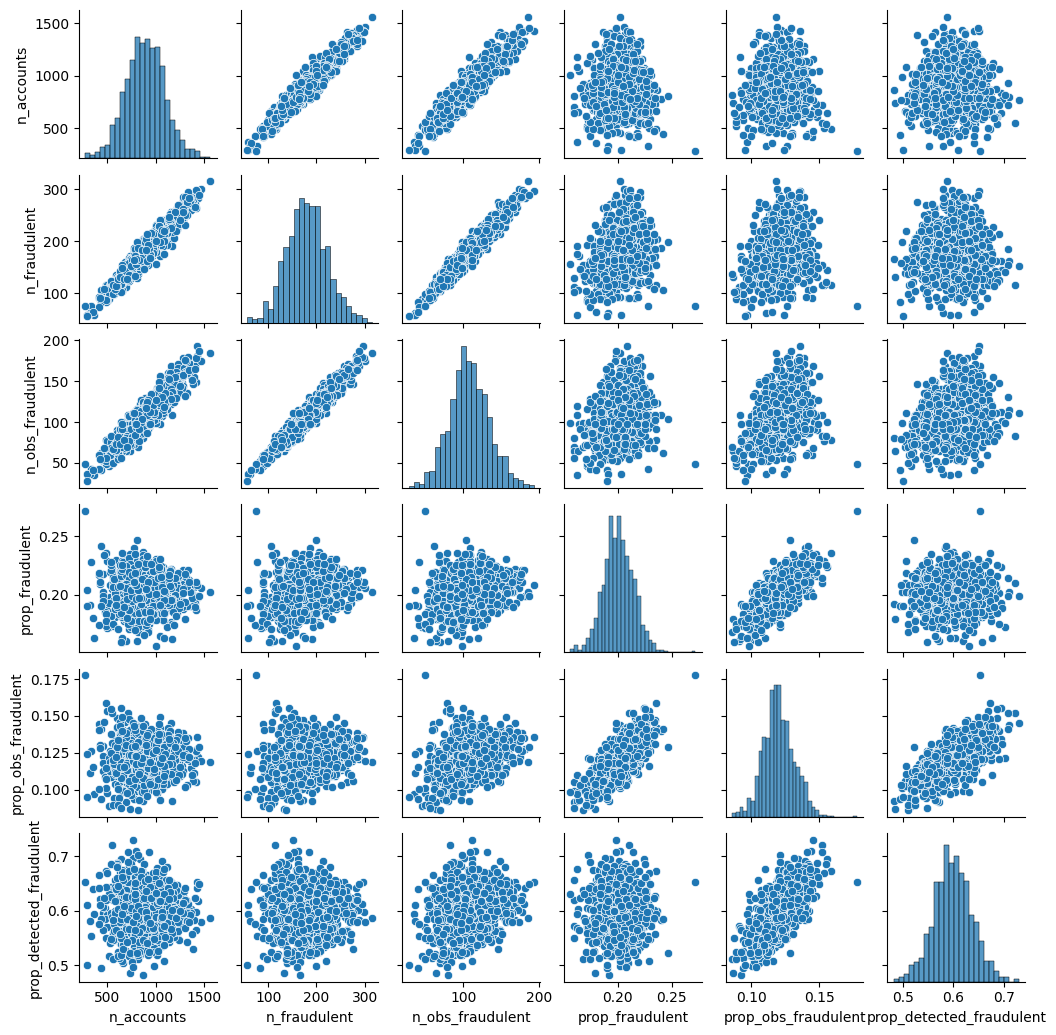

In [4]:
sns.pairplot(df1[['n_accounts', 'n_fraudulent', 'n_obs_fraudulent', 'prop_fraudulent', 'prop_obs_fraudulent', 'prop_detected_fraudulent']], height=1.75);

+ With this data generating model, there is a linear relationship between `n_obs_fraudulent` (number of detected/observed fraudulent accounts, and `n_fraudulent` - total number of fraudulent accounts created in a day.

# Model1

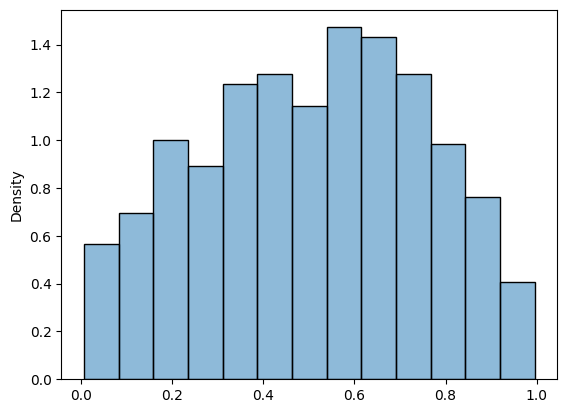

In [5]:
# Prior for probabilities - see https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist for pukka distribution shape
prob_dist = pd.Series(pm.Beta.dist(1.6, 1.6).random(size=1000))
sns.histplot(prob_dist, stat='density', discrete=False, alpha=0.5);

In [6]:
dfm = df1.copy()
# The data we see
dfm = dfm[['day', 'n_accounts', 'n_obs_fraudulent']]
dfm.head()

,day,n_accounts,n_obs_fraudulent
0,0,850,110
1,1,915,101
2,2,774,94
3,3,730,75
4,4,989,102


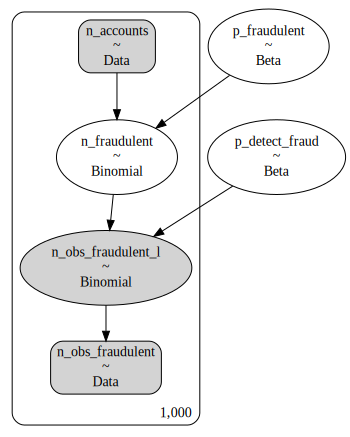

In [7]:
with pm.Model() as model1:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)

    # priors
    # p_detect_fraud = pm.Uniform('p_detect_fraud', 0.49, 0.99)
    # p_fraudulent = pm.Uniform('p_fraudulent', 0.01, 0.48)
    
    # Try shapes here - https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist
    p_detect_fraud = pm.Beta('p_detect_fraud', 1.6, 1.6)
    p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6)
        
    # Process Model
    n_fraudulent = pm.Binomial('n_fraudulent', n=n_accounts, p=p_fraudulent, shape=n_samples)
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_fraudulent, p=p_detect_fraud, observed=n_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    idata_model1 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model1)

In [8]:
# merge prior with original data


In [9]:
idata_model1

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

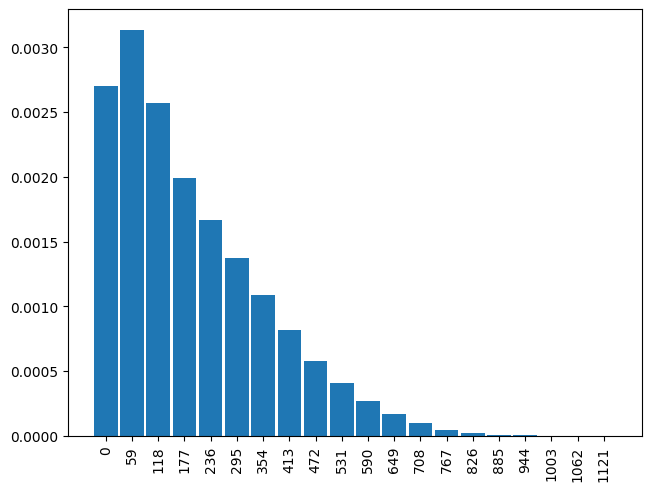

In [10]:
az.plot_dist(idata_model1.prior_predictive['n_obs_fraudulent_l'])
plt.xticks(rotation=90);

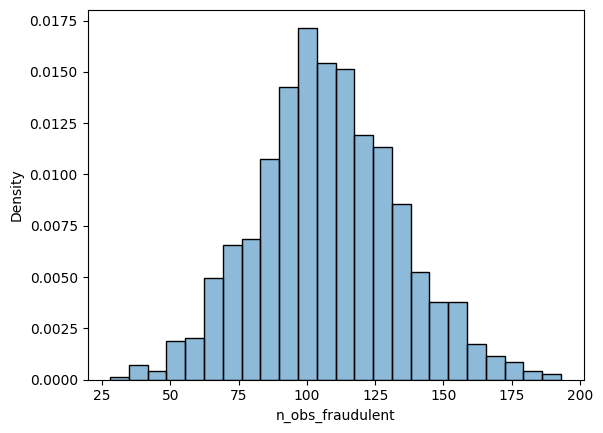

In [11]:
sns.histplot(dfm['n_obs_fraudulent'], stat='density', discrete=False, alpha=0.5);

In [12]:
with model1:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['n_fraudulent'])
    idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    # idata_model1.extend(az.from_pymc3(trace=trace))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_fraudulent, p_detect_fraud]
>Metropolis: [n_fraudulent]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
idata_model1

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> constant_data

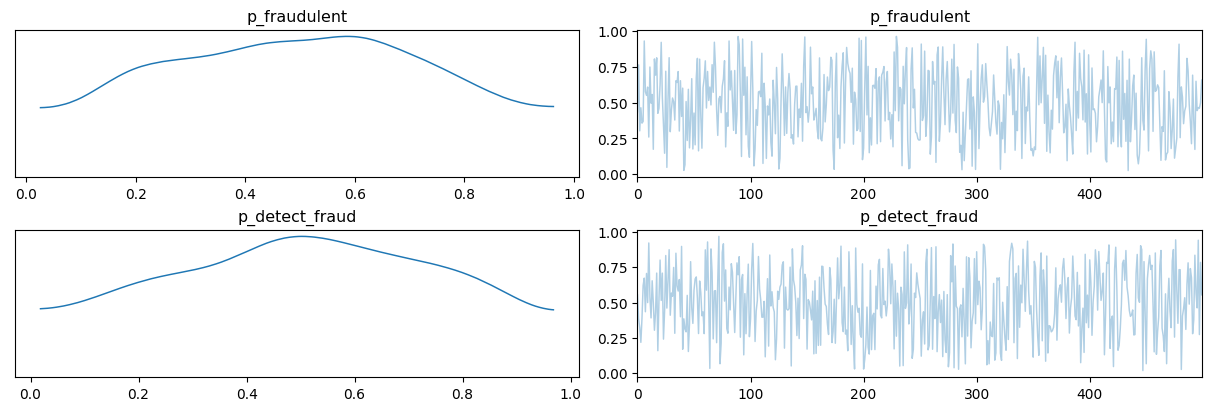

In [14]:
az.plot_trace(idata_model1.prior, var_names=['p_fraudulent', 'p_detect_fraud']);

In [15]:
### Check cell below for how well the model has recovered the original parameters


Actual probabilities the model is trying to recover - 0.2, 0.6



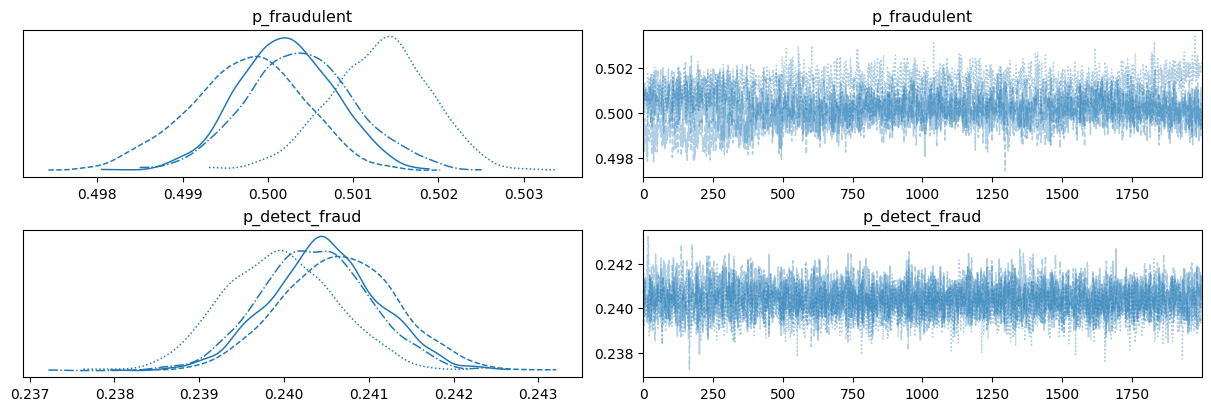

In [16]:
print(f"\nActual probabilities the model is trying to recover - {p_fraudulent_act}, {p_detect_fraud_act}\n") 
az.plot_trace(idata_model1, var_names=['p_fraudulent', 'p_detect_fraud']);

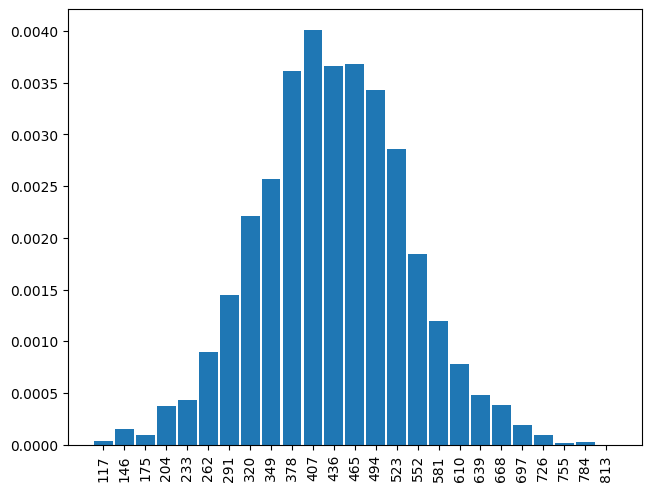

In [17]:
az.plot_dist(idata_model1.posterior['n_fraudulent'])
plt.xticks(rotation=90);

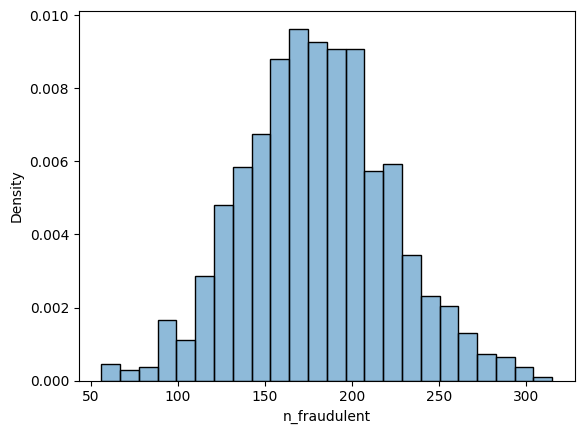

In [18]:
sns.histplot(df1['n_fraudulent'], stat='density', discrete=False, alpha=0.5);

### Out of Sample Prediction # 1

In [19]:
# On a particular day we see 1120 new accounts created, and we detect 125 fraudulent accounts - imaginary data
n_accounts_oos1 = 1120
n_obs_fraudulent_oos1 = 125
with model1:
    # data
    n_accounts = pm.set_data({'n_accounts': [n_accounts_oos1]})
    n_obs_fraudulent = pm.set_data({'n_obs_fraudulent': [n_obs_fraudulent_oos1]})
    # Pass in p_fraud, so thgat the model returns a posterior distribution for p_fraud based on the new data
    post_pred= pm.sample_posterior_predictive(trace, var_names=['p_fraudulent','p_detect_fraud'])
    idata_model1_oos1 = az.from_dict(post_pred)

In [20]:
idata_model1_oos1

Inference data with groups:
	> posterior

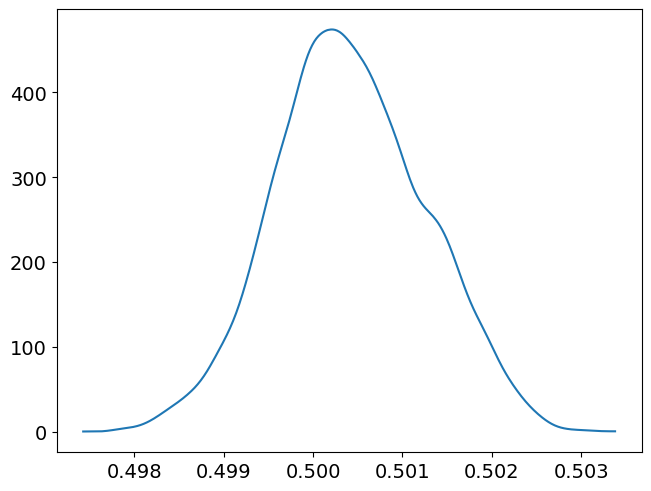

In [21]:
az.plot_dist(idata_model1_oos1.posterior['p_fraudulent']);

### Out of Sample Prediction # 2

In [22]:
# On a particular day we see 1120 new accounts created, and we detect 10 fraudulent accounts - imaginary data
n_accounts_oos2 = 1120
n_obs_fraudulent_oos2 = 0
with model1:
    # data
    n_accounts = pm.set_data({'n_accounts': [n_accounts_oos2]})
    n_obs_fraudulent = pm.set_data({'n_obs_fraudulent': [n_obs_fraudulent_oos2]})
    # Pass in p_fraud, so thgat the model returns a posterior distribution for p_fraud based on the new data
    post_pred= pm.sample_posterior_predictive(trace, var_names=['p_fraudulent', 'p_detect_fraud'])
    idata_model1_oos2 = az.from_dict(post_pred)  

In [23]:
idata_model1_oos2

Inference data with groups:
	> posterior

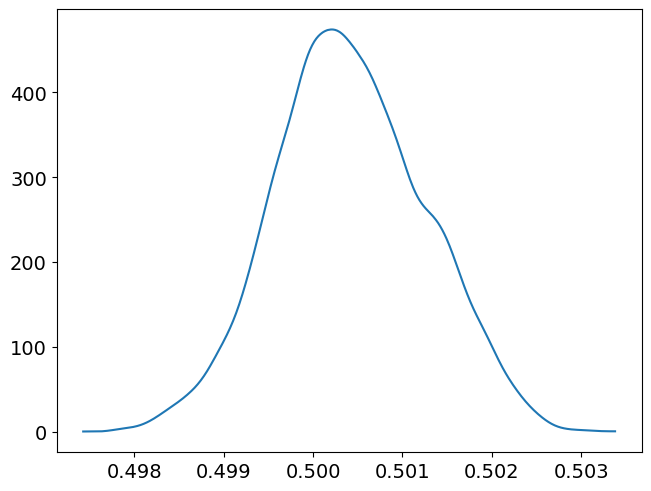

In [24]:
az.plot_dist(idata_model1_oos2.posterior['p_fraudulent']);

## Model 1 Comments
+ I cannot get this to converge, but it gets close
+ This is a simple model in that it assumes a constant probability of fraud - I think this is why it returns the same probability of fraud regardless of the new data inputs
+ The model gets mixed up as to which probability is which for `p_fraud` and `p_fraud_detect` - it sometimes swaps the posteriors for p_fraud and p_detect_fraud. Maybe this could be managed by constraining the priors to more reasonably fitting distributions, or maybe I have a coding error.

# Model 2
+ We know n_obs_fraudulent, and we know n_accounts
+ We want to find n_fraudulent which is equivalent to finding p_fraudulent
+ n_fraudulent = n_accounts x p_fraudulent (unknown = known x unknown param)
+ n_obs_fraudulent = n_fraudulent x p_detect_fraud (known = unknown x unknown param)
+ n_obs_fraudulent = n_accounts x p_fraudulent x p_detect_fraud (known = known x unknown param x unknown param)
+ So, our generating function is:
    + n_obs_fraudulent = n_accounts * p_fraudulent * p_detect_fraud
+ But this model cannot work because a probability distribution x another probability distribution = some other probability distribution - so the model will not be able to distinguish between the 2 probability distributions.
+ Therefore, we could consider the model in a different way


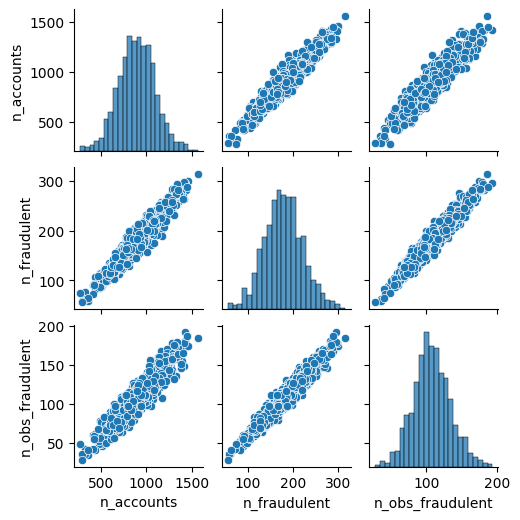

In [25]:
sns.pairplot(df1[['n_accounts', 'n_fraudulent', 'n_obs_fraudulent']], height=1.75);

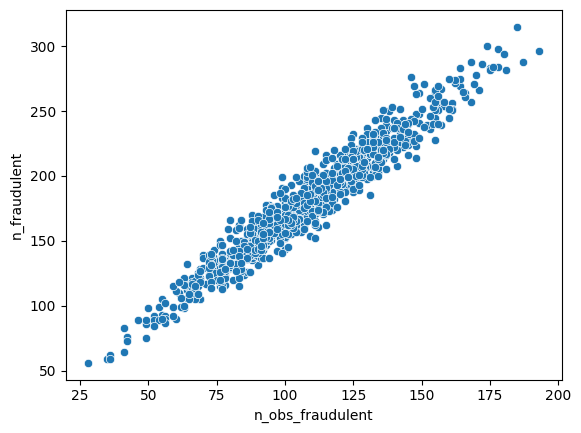

In [26]:
sns.scatterplot(data=df1, x='n_obs_fraudulent', y='n_fraudulent');
# sns.scatterplot(data=df, x='n_accounts', y='n_fraudulent')

In [27]:
res = linregress(df1['n_obs_fraudulent'].values, df1['n_fraudulent'].values)
res

LinregressResult(slope=1.5574880543860314, intercept=12.024261184255977, rvalue=0.9675279178039753, pvalue=0.0, stderr=0.01287986968355614, intercept_stderr=1.427112460883598)

In [28]:
n_samples = 1000
mu_accounts = 900
sigma_accounts = 200

# Change these 2 probs here to see if the model can recover them below
p_fraudulent_act = 0.15
p_detect_fraud_act = 0.60

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=mu_accounts, sigma=sigma_accounts, lower=0).random(size=n_samples)]
n_obs_fraudulent = pm.Binomial.dist(n=n_accounts, p=p_fraudulent_act * p_detect_fraud_act).random(size=n_samples)

df2 = pd.DataFrame({'day': range(n_samples), 'n_accounts': n_accounts, 'n_obs_fraudulent': n_obs_fraudulent})
df2

,day,n_accounts,n_obs_fraudulent
0,0,874,80
1,1,638,41
2,2,870,77
3,3,848,67
4,4,866,84
...,...,...,...
995,995,838,78
996,996,699,59
997,997,1292,116
998,998,910,87


In [29]:
dfm = df2.copy()
dfm.head()

,day,n_accounts,n_obs_fraudulent
0,0,874,80
1,1,638,41
2,2,870,77
3,3,848,67
4,4,866,84


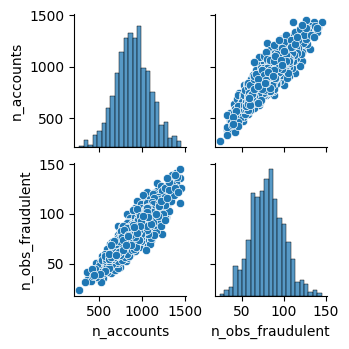

In [30]:
# This looks the same as the previos pairplot
sns.pairplot(df2[['n_accounts', 'n_obs_fraudulent']], height=1.75);

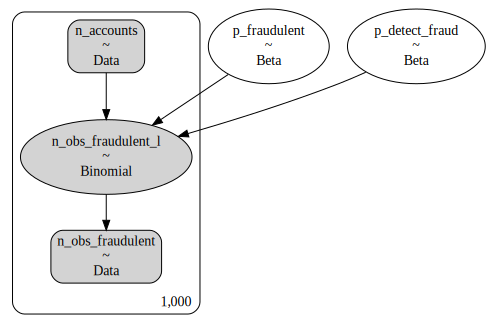

In [31]:
with pm.Model() as model2:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)

    # priors
    # p_detect_fraud = pm.Uniform('p_detect_fraud', 0.49, 0.99)
    # p_fraudulent = pm.Uniform('p_fraudulent', 0.01, 0.48)
    
    # Try shapes here - https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist
    p_detect_fraud = pm.Beta('p_detect_fraud', 1.6, 1.6)
    p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6)
        
    # Process Model
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_accounts, p=p_detect_fraud*p_fraudulent, observed=n_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    idata_model2 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model2)

In [32]:
idata_model2

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

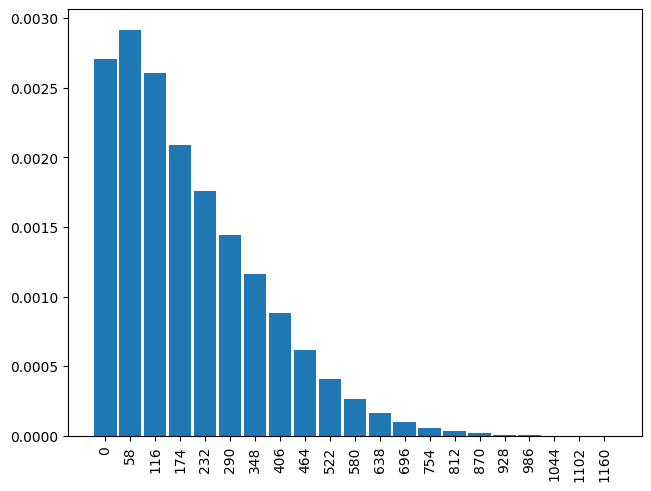

In [33]:
az.plot_dist(idata_model2.prior_predictive['n_obs_fraudulent_l'])
plt.xticks(rotation=90);

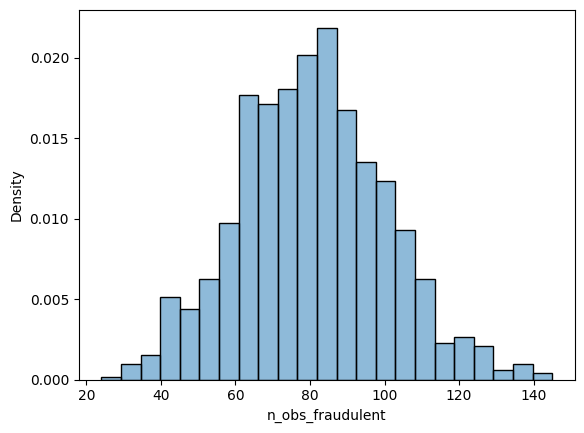

In [34]:
sns.histplot(dfm['n_obs_fraudulent'], stat='density', discrete=False, alpha=0.5);

In [35]:
with model2:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    # post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['p_fraudulent', 'p_detect_fraud'])
    # idata_model2.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model2.extend(az.from_pymc3(trace=trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_fraudulent, p_detect_fraud]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 203 seconds.
The acceptance probability does not match the target. It is 0.6898753951245851, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [36]:
idata_model2

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats
	> constant_data

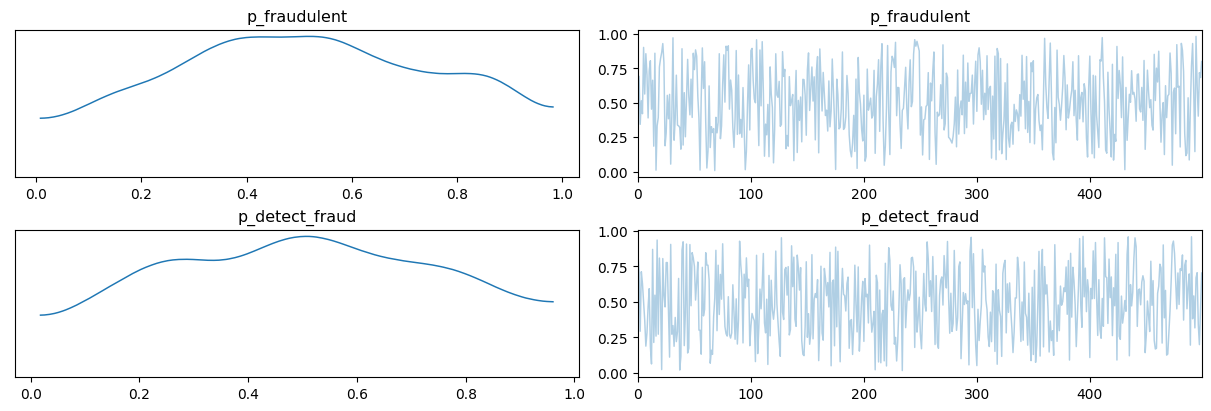

In [37]:
az.plot_trace(idata_model2.prior, var_names=['p_fraudulent', 'p_detect_fraud']);


Actual probabilities the model is trying to recover - 0.15, 0.6



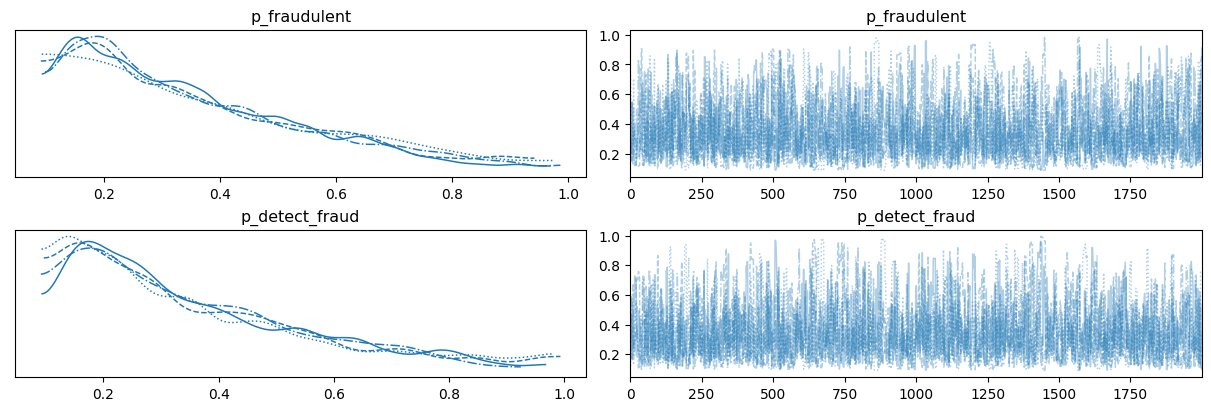

In [38]:
print(f"\nActual probabilities the model is trying to recover - {p_fraudulent_act}, {p_detect_fraud_act}\n") 
az.plot_trace(idata_model2, var_names=['p_fraudulent', 'p_detect_fraud']);

## Comments on Model 2
+ Fail

# Model 3
+ We will assume we have completed a gauge r&r type study and have defined the probability of detecting a fraudulent account given an account is fraudulent
+ This removes one of the parameters from the model

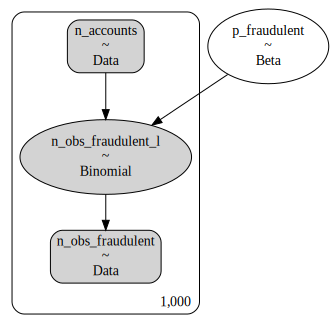

In [39]:
with pm.Model() as model3:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)

    # Try shapes here - https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist
    p_detect_fraud = p_detect_fraud_act
    p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6)
    
    # Process Model
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_accounts, p=p_detect_fraud*p_fraudulent, observed=n_obs_fraudulent)
        
    prior = pm.sample_prior_predictive()
    idata_model3 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model3)

In [40]:
idata_model3

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

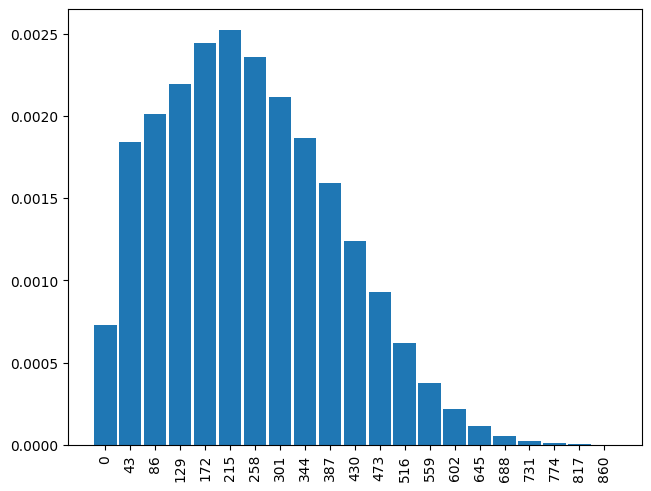

In [41]:
az.plot_dist(idata_model3.prior_predictive['n_obs_fraudulent_l'])
plt.xticks(rotation=90);

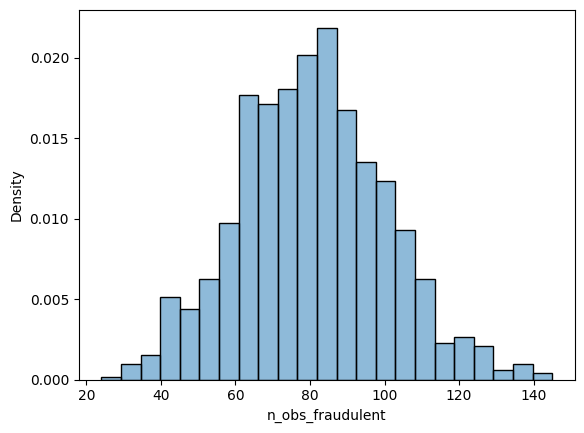

In [42]:
sns.histplot(dfm['n_obs_fraudulent'], stat='density', discrete=False, alpha=0.5);

In [43]:
with model3:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    # post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['n_fraudulent'])
    # idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model3.extend(az.from_pymc3(trace=trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_fraudulent]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 4 seconds.


In [44]:
idata_model3

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats
	> constant_data

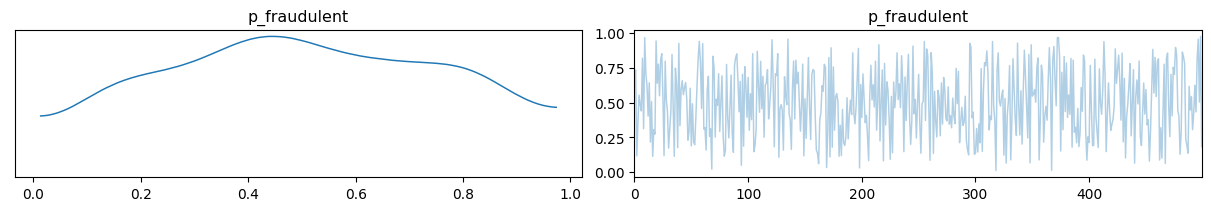

In [45]:
az.plot_trace(idata_model3.prior, var_names=['p_fraudulent']);


Actual probability the model is trying to recover - 0.15



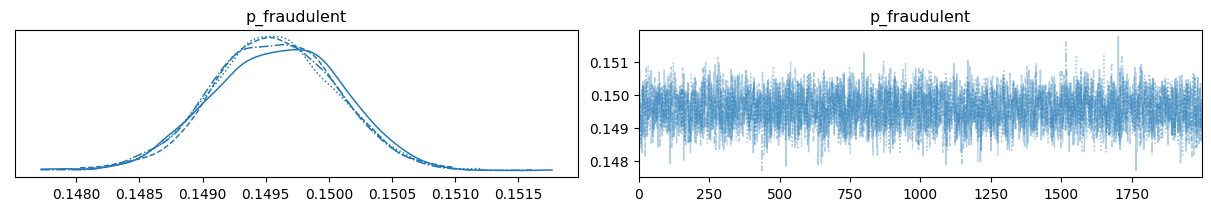

In [46]:
print(f"\nActual probability the model is trying to recover - {p_fraudulent_act}\n") 
az.plot_trace(idata_model3, var_names=['p_fraudulent']);

## Comments on model 3
+ seems to recover the percentage fraudulent, but I'm not too happy about having to constrain the probability of detection to a single value
+ I am not sure how to even calculate this number - unless it is something that can be calculated many days after the initial detection? 
+ Maybe a better option would be a quite narrow prior on the probability of detection, but this would need to be based on a an analysis of the data - try this next

# Model 4
+ Try narrow prior on probability of detection - but base it on the actual probability of detection used to generate the data

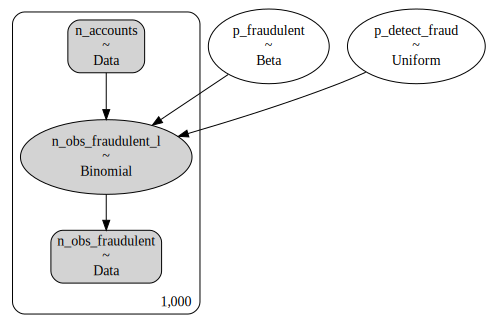

In [47]:
with pm.Model() as model4:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)

    # Try shapes here - https://ben18785.shinyapps.io/distribution-zoo/ - Continuous Univariate - Beta dist
    # Put a +/- 5% range around the actual value as the prior - this is pretty tightly constrained
    p_detect_fraud = pm.Uniform('p_detect_fraud', p_detect_fraud_act-0.05, p_detect_fraud_act + 0.05)
    p_fraudulent = pm.Beta('p_fraudulent', 1.6, 1.6)
    
    # Process Model
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_accounts, p=p_detect_fraud*p_fraudulent, observed=n_obs_fraudulent)
        
    prior = pm.sample_prior_predictive()
    idata_model4 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model4)

In [48]:
with model4:
    trace = pm.sample(draws=2000, tune=4000, return_inferencedata=False)
    # post_pred = pm.sample_posterior_predictive(trace=trace, var_names=['n_fraudulent'])
    # idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model4.extend(az.from_pymc3(trace=trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_fraudulent, p_detect_fraud]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 22 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6829056566935706, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


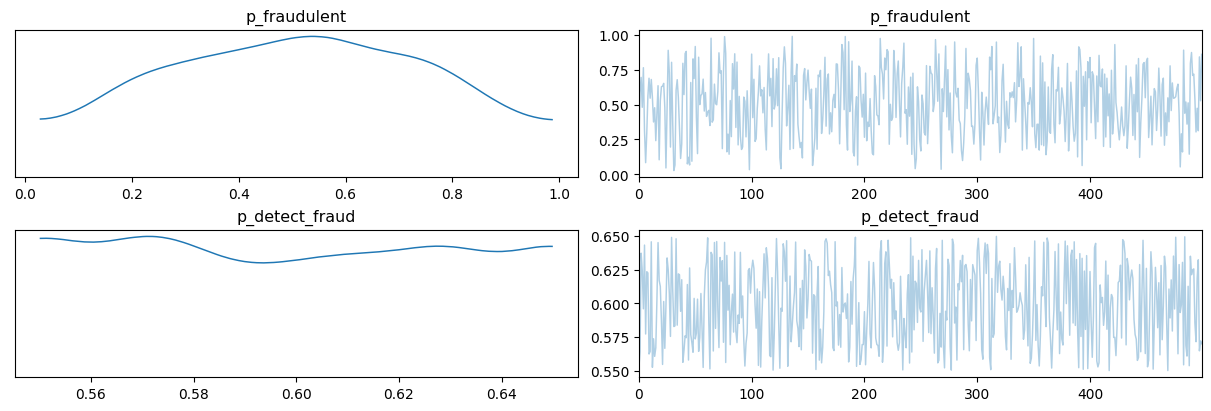

In [49]:
az.plot_trace(idata_model4.prior, var_names=['p_fraudulent', 'p_detect_fraud']);


Actual probabilities the model is trying to recover - 0.15, 0.6



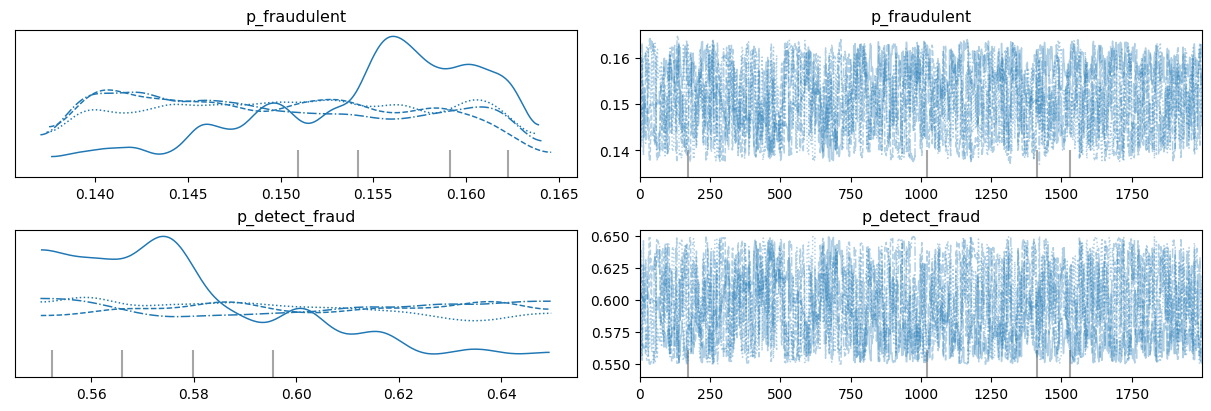

In [50]:
print(f"\nActual probabilities the model is trying to recover - {p_fraudulent_act}, {p_detect_fraud_act}\n") 
az.plot_trace(idata_model4, var_names=['p_fraudulent', 'p_detect_fraud']);

## Comments on Model 4
+ Gets close, but not really stable
+ I suspect multiplying distributions is causing the issue - I know what it means to multiply 2 probabilities together, but I have no idea what multiplying 2 distributions means
+ I think this is the wrong way of thinking about variation - maybe think of total variation as adding gauge variation to the variation around the proportion fraudulent